In [56]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yolo-blood-cell-annotated/Blood_Cell_Classification/test/labels/PLATELET_966169_jpg.rf.27a2beab0ba83a513710a07b8843133a.txt
/kaggle/input/yolo-blood-cell-annotated/Blood_Cell_Classification/test/labels/LY_618017_jpg.rf.2f60005f122a050984ce954ac65b2fe1.txt
/kaggle/input/yolo-blood-cell-annotated/Blood_Cell_Classification/test/labels/EO_219068_jpg.rf.a9eb3bef7cfa09d315b1b51f11a66086.txt
/kaggle/input/yolo-blood-cell-annotated/Blood_Cell_Classification/test/labels/LY_345919_jpg.rf.764e06be76449e2f08baf8a8aa1bbf6c.txt
/kaggle/input/yolo-blood-cell-annotated/Blood_Cell_Classification/test/labels/EO_843365_jpg.rf.c22a70f6a8829a452b6d467386018d94.txt
/kaggle/input/yolo-blood-cell-annotated/Blood_Cell_Classification/test/labels/SNE_185829_jpg.rf.49bd44cbe95b248e4bac6f63c7dc5990.txt
/kaggle/input/yolo-blood-cell-annotated/Blood_Cell_Classification/test/labels/LY_874739_jpg.rf.2c81c80beb95cc13e2d29f09eeed2659.txt
/kaggle/input/yolo-blood-cell-annotated/Blood_Cell_Classification/tes

In [57]:
import torch
import torch.nn as nn
import pandas as pd
import os
import PIL
import skimage
from skimage import io
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from torch.utils.data import DataLoader
from tqdm import tqdm
seed = 123
import cv2
import xml.etree.ElementTree as ET
torch.manual_seed(seed)
from collections import Counter

In [61]:
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import os
import glob
from PIL import Image
import numpy as np

class YOLODataset(Dataset):
    def __init__(self, img_dir, label_dir, img_size=640, transform=None):
        """
        Args:
            img_dir (string): Direktori berisi gambar.
            label_dir (string): Direktori berisi file label txt.
            img_size (int): Ukuran gambar input untuk model.
            transform (callable, optional): Transformasi opsional yang akan diterapkan pada sampel.
        """
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.img_size = img_size
        self.transform = transform

        self.image_files = sorted(glob.glob(os.path.join(img_dir, '*.jpg')))
        # Pastikan file label cocok dengan file gambar
        self.label_files = [
            os.path.join(label_dir, os.path.splitext(os.path.basename(f))[0] + '.txt')
            for f in self.image_files
        ]

        # Hapus pasangan gambar/label jika file label tidak ada
        valid_indices = [i for i, lf in enumerate(self.label_files) if os.path.exists(lf)]
        self.image_files = [self.image_files[i] for i in valid_indices]
        self.label_files = [self.label_files[i] for i in valid_indices]


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        label_path = self.label_files[idx]

        # Baca Gambar
        # Gunakan try-except untuk menangani gambar yang mungkin corrupt
        try:
            image = Image.open(img_path).convert('RGB')
            original_width, original_height = image.size
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Kembalikan sampel dummy atau lewati
            # Untuk kesederhanaan, kita bisa mengembalikan None dan menangani di DataLoader collate_fn
            # atau mengembalikan gambar dummy dan label kosong
            image = Image.new('RGB', (self.img_size, self.img_size), (0, 0, 0))
            original_width, original_height = image.size
            labels = np.empty((0, 5), dtype=np.float32)


        # Baca Label
        if os.path.exists(label_path):
            try:
              # Load labels, pastikan formatnya benar (misal, dipisahkan spasi)
              labels = np.loadtxt(label_path, delimiter=' ', ndmin=2, dtype=np.float32)
              # Pastikan shape benar jika hanya ada satu label
              if labels.ndim == 1:
                  labels = np.expand_dims(labels, axis=0)
              # Periksa apakah jumlah kolom adalah 5
              if labels.shape[1] != 5:
                  print(f"Warning: Label file {label_path} has incorrect format (shape {labels.shape}). Skipping labels.")
                  labels = np.empty((0, 5), dtype=np.float32) # Label kosong jika format salah
            except Exception as e:
              print(f"Error loading or parsing label file {label_path}: {e}")
              labels = np.empty((0, 5), dtype=np.float32) # Label kosong jika error

        else:
            # Jika tidak ada objek di gambar, file label mungkin tidak ada
            labels = np.empty((0, 5), dtype=np.float32) # Array kosong shape (0, 5)

        # Simpan label asli untuk transformasi jika diperlukan
        target = {'boxes': torch.from_numpy(labels[:, 1:]), # x_center, y_center, w, h
                  'labels': torch.from_numpy(labels[:, 0]).long()} # class_id

        # Terapkan Transformasi (misalnya, resize, augmentasi, normalisasi)
        # Penting: Anda perlu menyesuaikan bounding box jika melakukan resize atau augmentasi spasial!
        # Untuk implementasi awal, kita bisa mulai dengan resize sederhana.
        # Transformasi yang lebih kompleks (misal, mosaic, mixup) bisa ditambahkan nanti.

        # Contoh resize sederhana (tanpa penyesuaian bbox, asumsi transform menangani ini jika perlu)
        if self.transform:
            # Catatan: Transformasi standar torchvision mungkin tidak secara otomatis menyesuaikan bbox.
            # Anda mungkin perlu library seperti Albumentations atau implementasi kustom.
            # Untuk awal, kita resize saja gambarnya.
             image_resized = image.resize((self.img_size, self.img_size))
             image_tensor = T.ToTensor()(image_resized)
             image_tensor = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image_tensor) # Normalisasi standar ImageNet
        else:
             image_resized = image.resize((self.img_size, self.img_size))
             image_tensor = T.ToTensor()(image_resized)


        # Catatan penting tentang BBox setelah resize:
        # Format label YOLO (x_center, y_center, width, height) sudah dinormalisasi (0-1).
        # Jadi, resize gambar TIDAK mengubah koordinat bbox yang dinormalisasi ini.
        # Namun, jika Anda melakukan padding atau augmentasi lain, Anda HARUS menyesuaikannya.

        # Menggabungkan class_id dan bbox kembali untuk output
        # Format: [image_index, class_id, x_center, y_center, w, h]
        # image_index ditambahkan di collate_fn biasanya
        num_labels = labels.shape[0]
        labels_out = torch.zeros((num_labels, 6))
        if num_labels > 0:
            labels_out[:, 1:] = torch.from_numpy(labels) # class, cx, cy, w, h


        return image_tensor, labels_out # Kembalikan tensor gambar dan label

    @staticmethod
    def collate_fn(batch):
        images, labels = zip(*batch)
        # Tambahkan batch index ke labels
        for i, lbl in enumerate(labels):
            lbl[:, 0] = i  # Kolom pertama sekarang adalah batch index
        return torch.stack(images, 0), torch.cat(labels, 0)

# Contoh Penggunaan:
train_dataset = YOLODataset(img_dir='/kaggle/input/yolo-blood-cell-annotated/Blood_Cell_Classification/train/images', label_dir='/kaggle/input/yolo-blood-cell-annotated/Blood_Cell_Classification/train/labels')
test_dataset = YOLODataset(img_dir='/kaggle/input/yolo-blood-cell-annotated/Blood_Cell_Classification/test/images', label_dir='/kaggle/input/yolo-blood-cell-annotated/Blood_Cell_Classification/test/labels')
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, collate_fn=YOLODataset.collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, collate_fn=YOLODataset.collate_fn)

In [62]:
import torch
import torch.nn as nn

def autopad(k, p=None, d=1):  # kernel, padding, dilation
    """Menghitung padding agar output memiliki ukuran sama dengan input."""
    if d > 1:
        k = d * (k - 1) + 1 if isinstance(k, int) else [d * (x - 1) + 1 for x in k]  # Dilated kernel size
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # Auto padding
    return p

class Conv(nn.Module):
    """Standard convolution block with Batch normalization and SiLU activation."""
    default_act = nn.SiLU()  # Default activation

    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, d=1, act=True):
        """
        Args:
            c1 (int): Input channels.
            c2 (int): Output channels.
            k (int or tuple): Kernel size. Default: 1
            s (int or tuple): Stride. Default: 1
            p (int or tuple, optional): Padding. Default: None (autopad)
            g (int): Groups for grouped convolution. Default: 1
            d (int): Dilation rate. Default: 1
            act (bool or nn.Module): Use activation function. Default: True (use default_act)
        """
        super().__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, autopad(k, p, d), groups=g, dilation=d, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = self.default_act if act is True else (act if isinstance(act, nn.Module) else nn.Identity())

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

    def forward_fuse(self, x):
        """Forward method for fused BatchNorm layers."""
        return self.act(self.conv(x))

# Anda juga mungkin memerlukan blok lain seperti DWConv (Depthwise Convolution)
class DWConv(Conv):
    """Depthwise convolution."""
    def __init__(self, c1, c2, k=1, s=1, d=1, act=True):
        super().__init__(c1, c2, k, s, g=math.gcd(c1, c2), d=d, act=act)

# ... dan mungkin SPPF (Spatial Pyramid Pooling - Fast)
class SPPF(nn.Module):
    """Spatial Pyramid Pooling - Fast (SPPF) layer for YOLOv5 by Glenn Jocher."""
    def __init__(self, c1, c2, k=5):  # ch_in, ch_out, kernel
        super().__init__()
        c_ = c1 // 2  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_ * 4, c2, 1, 1)
        self.m = nn.MaxPool2d(kernel_size=k, stride=1, padding=k // 2)

    def forward(self, x):
        x = self.cv1(x)
        with torch.no_grad(): # Mencegah gradient computation untuk maxpool yang redundant
            y1 = self.m(x)
            y2 = self.m(y1)
            y3 = self.m(y2)
        return self.cv2(torch.cat((x, y1, y2, y3), 1))

In [63]:
import torch
import torch.nn as nn
import math

# Impor blok Conv dan DWConv dari langkah sebelumnya
# Pastikan class Conv dan DWConv sudah didefinisikan di atas kode ini
# (Seperti yang disediakan di respons saya sebelumnya)

class PositionPerceiver(nn.Module):
    """ Position Perceiver using large kernel Depthwise Convolution (7x7)."""
    def __init__(self, dim):
        super().__init__()
        # Menggunakan DWConv yang sudah kita definisikan sebelumnya
        # Kernel 7x7, stride 1, otomatis padding ('same' behavior)
        self.dwconv = DWConv(dim, dim, k=7, s=1, act=False) # Tidak ada aktivasi setelah DWConv

    def forward(self, x):
        return self.dwconv(x)

class AreaAttention(nn.Module):
    """
    Area Attention (A2) module as described in YOLOv12 paper.
    Divides feature map into segments (areas) and applies MHA within them.
    """
    def __init__(self, dim, num_heads=8, qkv_bias=True, attn_drop=0., proj_drop=0., num_segments=4, attention_type='A2-H'):
        """
        Args:
            dim (int): Input dimension (channels).
            num_heads (int): Number of attention heads.
            qkv_bias (bool): If True, add bias to query, key, value projections.
            attn_drop (float): Dropout rate for attention weights.
            proj_drop (float): Dropout rate for output projection.
            num_segments (int): Number of segments to divide the feature map into. Default 4.
            attention_type (str): 'A2-H' (Horizontal) or 'A2-V' (Vertical) segmentation.
        """
        super().__init__()
        assert dim % num_heads == 0, "dim should be divisible by num_heads"
        assert attention_type in ['A2-H', 'A2-V'], "attention_type must be 'A2-H' or 'A2-V'"

        self.dim = dim
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        self.num_segments = num_segments
        self.attention_type = attention_type

        # QKV projection layer
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        # Output projection layer
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        # Position Perceiver (7x7 DWConv)
        self.pos_perceiver = PositionPerceiver(dim)

        # Coba gunakan Flash Attention jika tersedia (memerlukan instalasi terpisah)
        self.use_flash_attn = hasattr(torch.nn.functional, 'scaled_dot_product_attention')


    def forward(self, x):
        B, C, H, W = x.shape
        # Terapkan Position Perceiver terlebih dahulu
        x = x + self.pos_perceiver(x) # Tambahkan output pos_perceiver ke input

        # Reshape dan Transpose untuk atensi: B, C, H, W -> B, H*W, C
        x_flat = x.flatten(2).transpose(1, 2)  # Shape: (B, N, C) where N = H*W

        # Dapatkan Q, K, V dari linear projection
        qkv = self.qkv(x_flat).reshape(B, H * W, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        # qkv shape: (3, B, num_heads, N, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]  # Shape masing-masing: (B, num_heads, N, head_dim)

        # Reshape q, k, v untuk Area Attention
        if self.attention_type == 'A2-H': # Segmen Horizontal
            # Bagi N (H*W) menjadi num_segments kelompok sepanjang dimensi W
            # N = H * W -> (H * num_segments) * (W / num_segments) ? Tidak, ini lebih rumit.
            # Kita perlu membagi H atau W nya sebelum flatten.
            # Reshape input x: B, C, H, W
            if W % self.num_segments != 0:
                 raise ValueError(f"Width {W} must be divisible by num_segments {self.num_segments} for A2-H")
            seg_w = W // self.num_segments
            # Reshape menjadi (B, C, H, num_segments, seg_w) -> (B*num_segments, C, H, seg_w)
            x_reshaped = x.reshape(B, C, H, self.num_segments, seg_w).permute(0, 3, 1, 2, 4).reshape(B * self.num_segments, C, H, seg_w)
            # Flatten untuk atensi: (B*num_segments, C, H*seg_w) -> (B*num_segments, H*seg_w, C)
            x_flat_seg = x_reshaped.flatten(2).transpose(1, 2) # Shape: (B*seg, N_seg, C) where N_seg = H*seg_w

            # Hitung QKV lagi pada x_flat_seg
            qkv_seg = self.qkv(x_flat_seg).reshape(B * self.num_segments, H * seg_w, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
            q_seg, k_seg, v_seg = qkv_seg[0], qkv_seg[1], qkv_seg[2] # Shape: (B*seg, num_heads, N_seg, head_dim)

            if self.use_flash_attn:
                 # Menggunakan scaled_dot_product_attention bawaan PyTorch (lebih efisien)
                 attn_output = torch.nn.functional.scaled_dot_product_attention(
                     q_seg, k_seg, v_seg,
                     attn_mask=None,
                     dropout_p=self.attn_drop.p if self.training else 0.0,
                     is_causal=False
                 ) # Shape: (B*seg, num_heads, N_seg, head_dim)
            else:
                # Implementasi manual jika Flash Attention tidak tersedia
                attn = (q_seg @ k_seg.transpose(-2, -1)) * self.scale
                attn = attn.softmax(dim=-1)
                attn = self.attn_drop(attn)
                attn_output = (attn @ v_seg) # Shape: (B*seg, num_heads, N_seg, head_dim)

            # Reshape kembali output atensi
            # (B*seg, num_heads, N_seg, head_dim) -> (B*seg, N_seg, C) -> (B*seg, C, H, seg_w) -> (B, C, H, W)
            attn_output = attn_output.transpose(1, 2).reshape(B * self.num_segments, H * seg_w, C) # (B*seg, N_seg, C)
            # Kembalikan ke format gambar
            # (B*seg, N_seg, C) -> (B*seg, C, N_seg) -> (B*seg, C, H, seg_w)
            attn_output = attn_output.transpose(1, 2).reshape(B * self.num_segments, C, H, seg_w)
            # Gabungkan segmen: (B*seg, C, H, seg_w) -> (B, num_segments, C, H, seg_w) -> (B, C, H, num_segments, seg_w) -> (B, C, H, W)
            x = attn_output.reshape(B, self.num_segments, C, H, seg_w).permute(0, 2, 3, 1, 4).reshape(B, C, H, W)


        elif self.attention_type == 'A2-V': # Segmen Vertikal
            # Logika serupa dengan A2-H, tetapi reshape berdasarkan H
            if H % self.num_segments != 0:
                 raise ValueError(f"Height {H} must be divisible by num_segments {self.num_segments} for A2-V")
            seg_h = H // self.num_segments
            # Reshape: (B, C, num_segments, seg_h, W) -> (B*num_segments, C, seg_h, W)
            x_reshaped = x.reshape(B, C, self.num_segments, seg_h, W).permute(0, 2, 1, 3, 4).reshape(B * self.num_segments, C, seg_h, W)
            # Flatten: (B*seg, C, seg_h*W) -> (B*seg, seg_h*W, C)
            x_flat_seg = x_reshaped.flatten(2).transpose(1, 2) # Shape: (B*seg, N_seg, C) where N_seg = seg_h*W

            qkv_seg = self.qkv(x_flat_seg).reshape(B * self.num_segments, seg_h * W, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
            q_seg, k_seg, v_seg = qkv_seg[0], qkv_seg[1], qkv_seg[2]

            if self.use_flash_attn:
                 attn_output = torch.nn.functional.scaled_dot_product_attention(
                     q_seg, k_seg, v_seg,
                     attn_mask=None,
                     dropout_p=self.attn_drop.p if self.training else 0.0,
                     is_causal=False)
            else:
                attn = (q_seg @ k_seg.transpose(-2, -1)) * self.scale
                attn = attn.softmax(dim=-1)
                attn = self.attn_drop(attn)
                attn_output = (attn @ v_seg) # Shape: (B*seg, num_heads, N_seg, head_dim)

            # Reshape kembali
            # (B*seg, num_heads, N_seg, head_dim) -> (B*seg, N_seg, C) -> (B*seg, C, N_seg) -> (B*seg, C, seg_h, W)
            attn_output = attn_output.transpose(1, 2).reshape(B * self.num_segments, seg_h * W, C)
            attn_output = attn_output.transpose(1, 2).reshape(B * self.num_segments, C, seg_h, W)
            # Gabungkan: (B*seg, C, seg_h, W) -> (B, num_segments, C, seg_h, W) -> (B, C, num_segments, seg_h, W) -> (B, C, H, W)
            x = attn_output.reshape(B, self.num_segments, C, seg_h, W).permute(0, 2, 1, 3, 4).reshape(B, C, H, W)

        # Terapkan proyeksi output setelah atensi
        # Perlu reshape x ke (B, N, C) lagi untuk linear projection
        x_flat_out = x.flatten(2).transpose(1, 2)
        x_projected = self.proj(x_flat_out)
        x_projected = self.proj_drop(x_projected)

        # Reshape kembali ke format gambar: (B, N, C) -> (B, C, H, W)
        out = x_projected.transpose(1, 2).reshape(B, C, H, W)

        return out

class MLP(nn.Module):
    """ Standard MLP block."""
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.SiLU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        # Paper menyebutkan rasio MLP yang disesuaikan (1.2 atau 2.0), ini bisa diatur via hidden_features
        # Contoh: hidden_features = int(in_features * 1.2)
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        # Input MLP biasanya flat (B, N, C)
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class AttentionBlock(nn.Module):
    """ Combines AreaAttention and MLP with LayerNorm."""
    def __init__(self, dim, num_heads, mlp_ratio=2.0, qkv_bias=True, drop=0., attn_drop=0.,
                 norm_layer=nn.LayerNorm, act_layer=nn.SiLU, num_segments=4, attention_type='A2-H'):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = AreaAttention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop,
                                  num_segments=num_segments, attention_type=attention_type)
        # LayerNorm diganti Conv+BN di paper, tapi mari kita mulai dengan LayerNorm dulu
        # self.norm1_conv = nn.BatchNorm2d(dim) # Alternatif jika menggunakan Conv+BN

        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
        # self.norm2_conv = nn.BatchNorm2d(dim) # Alternatif jika menggunakan Conv+BN

    def forward(self, x):
        # x shape: B, C, H, W
        B, C, H, W = x.shape

        # Atensi:
        # Jika pakai LayerNorm, perlu reshape B,C,H,W -> B,N,C
        x_norm1_flat = self.norm1(x.flatten(2).transpose(1, 2))
        x_norm1 = x_norm1_flat.transpose(1, 2).reshape(B, C, H, W)
        x = x + self.attn(x_norm1) # Skip connection 1

        # MLP:
        # Jika pakai LayerNorm
        x_norm2_flat = self.norm2(x.flatten(2).transpose(1, 2))
        mlp_out_flat = self.mlp(x_norm2_flat)
        mlp_out = mlp_out_flat.transpose(1, 2).reshape(B, C, H, W)
        x = x + mlp_out # Skip connection 2

        return x

In [64]:
# Impor blok Conv yang sudah didefinisikan sebelumnya

class RELANBlock(nn.Module):
    """Residual Efficient Layer Aggregation Networks (R-ELAN) block."""
    def __init__(self, c1, c2, c_hidden, num_attn_blocks=1, num_heads=8, mlp_ratio=2.0,
                 num_segments=4, attention_type='A2-H', residual_scale=0.01, act_layer=nn.SiLU):
        """
        Args:
            c1 (int): Input channels.
            c2 (int): Output channels.
            c_hidden (int): Hidden channels within the block branches.
            num_attn_blocks (int): Number of AttentionBlocks in the attention branch.
            num_heads (int): Number of heads for AreaAttention.
            mlp_ratio (float): MLP expansion ratio for AttentionBlock.
            num_segments (int): Number of segments for AreaAttention.
            attention_type (str): 'A2-H' or 'A2-V' for AreaAttention.
            residual_scale (float): Scaling factor for the block-level residual connection.
                                     Set to 0 or very small for N-scale models as per paper.
            act_layer (nn.Module): Activation function.
        """
        super().__init__()
        self.residual_scale = residual_scale

        # Cabang 1: Konvolusi 1x1 untuk menyesuaikan channel
        self.cv1 = Conv(c1, c_hidden, k=1, s=1, act=act_layer)

        # Cabang 2: Konvolusi 1x1 diikuti AttentionBlocks
        self.cv2 = Conv(c1, c_hidden, k=1, s=1, act=act_layer)
        self.attn_branch = nn.Sequential(
            *[AttentionBlock(dim=c_hidden, num_heads=num_heads, mlp_ratio=mlp_ratio,
                             num_segments=num_segments, attention_type=attention_type,
                             act_layer=act_layer) # Gunakan LayerNorm sementara
              for _ in range(num_attn_blocks)]
        )

        # Cabang 3 & 4 (Struktur ELAN standar, bisa bervariasi)
        # Contoh sederhana:
        self.cv3 = Conv(c_hidden, c_hidden // 2, k=1, s=1, act=act_layer)
        self.cv4 = Conv(c_hidden // 2, c_hidden // 2, k=3, s=1, act=act_layer) # Konvolusi 3x3
        self.cv5 = Conv(c_hidden // 2, c_hidden // 2, k=3, s=1, act=act_layer) # Konvolusi 3x3

        # Konvolusi akhir untuk menggabungkan semua cabang
        # Input: cv1_out + attn_out + cv4_out + cv5_out
        # Total channel: c_hidden + c_hidden + c_hidden//2 + c_hidden//2 = 3 * c_hidden
        self.cv_out = Conv(c_hidden * 3, c2, k=1, s=1, act=act_layer)


    def forward(self, x):
        # Simpan input untuk residual connection
        identity = x

        # Cabang 1
        x1 = self.cv1(x)

        # Cabang 2 (Attention)
        x2 = self.cv2(x)
        x_attn = self.attn_branch(x2)

        # Cabang 3 & 4 (Contoh)
        x3 = self.cv3(x_attn) # Input dari cabang atensi
        x4 = self.cv4(x3)
        x5 = self.cv5(x4)

        # Gabungkan cabang-cabang
        # Perhatikan: Paper Fig 4b menunjukkan concat(cv1, cv3, cv4, cv5)?
        # Mari ikuti struktur bottleneck ELAN pada umumnya:
        # Output dari cabang 2 (attn) menjadi input cabang berikutnya
        # Mari revisi sedikit:
        # Cabang 1: Conv 1x1
        y1 = self.cv1(x)
        # Cabang 2: Conv 1x1 -> Attention
        y2 = self.cv2(x)
        y_attn = self.attn_branch(y2)
        # Cabang 3: Conv 1x1 (dari attn) -> Conv 3x3
        y3 = self.cv3(y_attn) # Menggunakan c_hidden//2 channels
        y4 = self.cv4(y3)     # Menggunakan c_hidden//2 channels
        # Cabang 4: Conv 3x3 (dari y4)
        y5 = self.cv5(y4)     # Menggunakan c_hidden//2 channels

        # Concat: y1, y_attn, y4, y5 ? (Jumlah channel?)
        # y1: c_hidden
        # y_attn: c_hidden
        # y4: c_hidden//2
        # y5: c_hidden//2
        # Total = 3 * c_hidden
        concat_features = torch.cat((y1, y_attn, y4, y5), dim=1)

        # Konvolusi output
        out = self.cv_out(concat_features)

        # Tambahkan residual connection dengan scaling
        if self.residual_scale > 0:
            # Perlu penyesuaian channel jika c1 != c2
            if identity.shape[1] != out.shape[1]:
                 # Opsi 1: Proyeksi identity (misal, dengan Conv 1x1)
                 # Opsi 2: Jangan tambahkan residual jika channel tidak cocok (lebih aman)
                 # Untuk R-ELAN, biasanya input dan output channel sama (c1=c2)
                 # Jika berbeda, mungkin residual tidak diterapkan atau perlu proyeksi
                 if identity.shape == out.shape: # Hanya tambah jika shape sama
                    return identity + self.residual_scale * out
                 else:
                     print(f"Warning: Skipping residual connection in RELANBlock due to shape mismatch: {identity.shape} vs {out.shape}")
                     return out # Kembalikan output tanpa residual
            else:
                 return identity + self.residual_scale * out
        else:
            return out # Tidak ada residual connection

In [65]:
import torch
import torch.nn as nn
import math

# --- Pastikan class Conv, DWConv, PositionPerceiver, AreaAttention, ---
# --- MLP, AttentionBlock, dan RELANBlock sudah didefinisikan di atas kode ini ---
# (Kode dari respons sebelumnya)

# Placeholder untuk blok awal (misal, mirip C3/GELAN di YOLOv11)
# Kita bisa buat versi sederhana menggunakan Conv saja untuk saat ini
class PlaceholderELAN(nn.Module):
    """ Placeholder block for early stages, mimicking ELAN/C3 structure simply."""
    def __init__(self, c1, c2, c_hidden, n=1, act_layer=nn.SiLU):
        super().__init__()
        self.cv1 = Conv(c1, c_hidden, k=1, s=1, act=act_layer)
        self.cv2 = Conv(c1, c_hidden, k=1, s=1, act=act_layer)
        # Serangkaian konvolusi 3x3
        self.blocks = nn.Sequential(*[
            nn.Sequential(Conv(c_hidden, c_hidden, k=3, s=1, act=act_layer))
            for _ in range(n)
        ])
        # Konvolusi output
        self.cv_out = Conv(c_hidden * 2, c2, k=1, s=1, act=act_layer)

    def forward(self, x):
        y1 = self.cv1(x)
        y2 = self.blocks(self.cv2(x))
        return self.cv_out(torch.cat((y1, y2), dim=1))


class YOLOv12Backbone(nn.Module):
    def __init__(self, base_channels=64, base_depth=3, # Skala dasar (misal untuk S/M)
                 deepen_factor=1.0, widen_factor=1.0, # Faktor skala untuk L/X
                 num_classes=80, # Hanya diperlukan jika head terintegrasi
                 mlp_ratio=2.0, num_segments=4, residual_scale=0.01, act_layer=nn.SiLU):
        """
        Args:
            base_channels (int): Base channel count.
            base_depth (int): Base number of blocks in stages.
            deepen_factor (float): Scales the number of blocks.
            widen_factor (float): Scales the number of channels.
            mlp_ratio (float): MLP ratio in AttentionBlocks.
            num_segments (int): Segments for AreaAttention.
            residual_scale (float): Scale for R-ELAN residual connection.
            act_layer (nn.Module): Activation function.
        """
        super().__init__()

        # Hitung channel dan depth berdasarkan faktor skala
        def scale_channels(c):
            return math.ceil(c * widen_factor / 8) * 8 # Pastikan kelipatan 8

        def scale_depth(d):
            return max(round(d * deepen_factor), 1) # Minimal 1 blok

        # Channels
        c_stem = scale_channels(base_channels // 2) # 32
        c1 = scale_channels(base_channels)      # 64
        c2 = scale_channels(base_channels * 2)  # 128
        c3 = scale_channels(base_channels * 4)  # 256
        c4 = scale_channels(base_channels * 8)  # 512
        c5 = scale_channels(base_channels * 12) # 768 (atau 1024 jika base*16)

        # Depth (Jumlah blok R-ELAN/Placeholder di setiap stage)
        n2 = scale_depth(base_depth)      # Misal 3
        n3 = scale_depth(base_depth * 2)  # Misal 6
        n4 = scale_depth(base_depth * 2)  # Misal 6
        n5 = 1 # Paper: Last stage has reduced depth (single R-ELAN block)

        # --- Stem ---
        # Konvolusi awal, misal 6x6 stride 2 (mirip YOLOv5)
        self.stem = Conv(3, c_stem, k=6, s=2, p=2, act=act_layer) # Output: W/2, H/2

        # --- Stage 1 ---
        # Konvolusi sederhana setelah stem
        self.stage1 = Conv(c_stem, c1, k=3, s=2, act=act_layer) # Output: W/4, H/4

        # --- Stage 2 ---
        # Placeholder ELAN/C3 block (sesuai paper mewarisi dari v11)
        self.stage2_downsample = Conv(c1, c2, k=3, s=2, act=act_layer) # Output: W/8, H/8
        self.stage2_blocks = PlaceholderELAN(c2, c2, c_hidden=c2 // 2, n=n2, act_layer=act_layer)

        # --- Stage 3 ---
        # Mulai menggunakan R-ELAN dengan Area Attention
        self.stage3_downsample = Conv(c2, c3, k=3, s=2, act=act_layer) # Output: W/16, H/16
        # Alternating Attention? A2-H, A2-V, A2-H, ...
        self.stage3_blocks = nn.Sequential(*[
            RELANBlock(c3, c3, c_hidden=c3 // 2, num_attn_blocks=1, num_heads=8,
                       mlp_ratio=mlp_ratio, num_segments=num_segments,
                       attention_type='A2-H' if i % 2 == 0 else 'A2-V', # Contoh Alternating
                       residual_scale=residual_scale, act_layer=act_layer)
            for i in range(n3)
        ])

        # --- Stage 4 ---
        self.stage4_downsample = Conv(c3, c4, k=3, s=2, act=act_layer) # Output: W/32, H/32
        self.stage4_blocks = nn.Sequential(*[
            RELANBlock(c4, c4, c_hidden=c4 // 2, num_attn_blocks=1, num_heads=8,
                       mlp_ratio=mlp_ratio, num_segments=num_segments,
                       attention_type='A2-H' if i % 2 == 0 else 'A2-V', # Contoh Alternating
                       residual_scale=residual_scale, act_layer=act_layer)
            for i in range(n4)
        ])

        # --- Stage 5 ---
        # Kedalaman dikurangi (hanya 1 R-ELAN block)
        self.stage5_downsample = Conv(c4, c5, k=3, s=2, act=act_layer) # Output: W/64, H/64
        # Hanya satu blok R-ELAN
        self.stage5_block = RELANBlock(c5, c5, c_hidden=c5 // 2, num_attn_blocks=1, num_heads=8,
                                         mlp_ratio=mlp_ratio, num_segments=num_segments,
                                         attention_type='A2-H', # Atau A2-V?
                                         residual_scale=residual_scale, act_layer=act_layer)

        # Inisialisasi bobot (opsional tapi direkomendasikan)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Stem
        x = self.stem(x)
        # Stage 1
        x = self.stage1(x)
        # Stage 2
        x = self.stage2_downsample(x)
        x = self.stage2_blocks(x)
        # Stage 3 -> Output P3 (untuk Neck)
        x = self.stage3_downsample(x)
        p3 = self.stage3_blocks(x)
        # Stage 4 -> Output P4 (untuk Neck)
        x = self.stage4_downsample(p3)
        p4 = self.stage4_blocks(x)
        # Stage 5 -> Output P5 (untuk Neck)
        x = self.stage5_downsample(p4)
        p5 = self.stage5_block(x)

        # Mengembalikan feature map dari stage yang relevan untuk Neck
        return p3, p4, p5 # Fitur dari stride 16, 32, 64

In [66]:
import torch
import torch.nn as nn
import math

# --- Pastikan class Conv, DWConv, PositionPerceiver, AreaAttention, ---
# --- MLP, AttentionBlock, RELANBlock, PlaceholderELAN, ---
# --- dan YOLOv12Backbone sudah didefinisikan di atas kode ini ---

class YOLOv12Neck(nn.Module):
    def __init__(self, c3_in=256, c4_in=512, c5_in=768, # Channel input dari backbone P3, P4, P5
                 neck_channels=None, # Channel internal/output Neck (jika None, gunakan input)
                 neck_depth=1, # Jumlah blok RELAN/Placeholder per stage di Neck
                 mlp_ratio=2.0, num_segments=4, residual_scale=0.01, act_layer=nn.SiLU):
        """
        Args:
            c3_in, c4_in, c5_in (int): Channel input dari output backbone P3, P4, P5.
            neck_channels (list or tuple, optional): Channel output untuk N3, N4, N5.
                                                     Jika None, akan sama dengan c3_in, c4_in, c5_in.
            neck_depth (int): Jumlah blok RELAN/Placeholder setelah merge di setiap level.
            mlp_ratio (float): MLP ratio di RELANBlock.
            num_segments (int): Segments for AreaAttention in RELANBlock.
            residual_scale (float): Scale for RELANBlock residual connection.
            act_layer (nn.Module): Activation function.
        """
        super().__init__()

        if neck_channels is None:
            c3_out, c4_out, c5_out = c3_in, c4_in, c5_in
        else:
            assert len(neck_channels) == 3, "neck_channels must have 3 values for N3, N4, N5"
            c3_out, c4_out, c5_out = neck_channels

        # --- Top-Down Path (P5 -> P4 -> P3) ---

        # Upsample P5 dan gabungkan dengan P4
        self.upsample_p5 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv_p5_td = Conv(c5_in, c4_out, k=1, s=1, act=act_layer) # Conv 1x1 untuk P5 sebelum merge
        self.conv_p4_in = Conv(c4_in, c4_out, k=1, s=1, act=act_layer) # Conv 1x1 untuk P4 sebelum merge
        # Blok RELAN setelah merge P5 dan P4
        self.relan_p4_td = nn.Sequential(*[
            RELANBlock(c4_out * 2, c4_out, c_hidden=c4_out // 2, num_attn_blocks=1, num_heads=8,
                       mlp_ratio=mlp_ratio, num_segments=num_segments, attention_type='A2-H', # Misal H
                       residual_scale=residual_scale, act_layer=act_layer)
            for _ in range(neck_depth) # Jumlah blok bisa disesuaikan
        ])

        # Upsample hasil P4_td dan gabungkan dengan P3
        self.upsample_p4 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv_p4_td_out = Conv(c4_out, c3_out, k=1, s=1, act=act_layer) # Conv 1x1 P4_td sebelum merge
        self.conv_p3_in = Conv(c3_in, c3_out, k=1, s=1, act=act_layer) # Conv 1x1 untuk P3 sebelum merge
        # Blok RELAN setelah merge P4_td dan P3 -> menghasilkan N3
        self.relan_p3_td = nn.Sequential(*[
             RELANBlock(c3_out * 2, c3_out, c_hidden=c3_out // 2, num_attn_blocks=1, num_heads=8,
                       mlp_ratio=mlp_ratio, num_segments=num_segments, attention_type='A2-V', # Misal V
                       residual_scale=residual_scale, act_layer=act_layer)
            for _ in range(neck_depth)
        ])
        # Output Top-Down pertama adalah N3 (hasil dari self.relan_p3_td)

        # --- Bottom-Up Path (N3 -> N4 -> N5) ---

        # Downsample N3 dan gabungkan dengan P4_td (hasil relan_p4_td)
        self.downsample_n3 = Conv(c3_out, c3_out, k=3, s=2, act=act_layer) # Downsampling N3
        # P4_td sudah punya channel c4_out. N3_downsampled punya c3_out. Perlu disamakan.
        # Opsi 1: Ubah c3_out di downsample menjadi c4_out//2 atau semacamnya
        # Opsi 2: Gunakan Conv 1x1 pada P4_td
        # Mari gunakan Conv 1x1 pada P4_td (output dari relan_p4_td)
        self.conv_p4_td_bu = Conv(c4_out, c4_out, k=1, s=1, act=act_layer) # Input untuk concat
        self.conv_n3_down = Conv(c3_out, c3_out, k=1, s=1, act=act_layer)   # Input untuk concat
        # Blok RELAN setelah merge N3_down dan P4_td -> menghasilkan N4
        self.relan_n4_bu = nn.Sequential(*[
            RELANBlock(c4_out + c3_out, c4_out, c_hidden=c4_out // 2, num_attn_blocks=1, num_heads=8,
                       mlp_ratio=mlp_ratio, num_segments=num_segments, attention_type='A2-H', # Misal H
                       residual_scale=residual_scale, act_layer=act_layer)
            for _ in range(neck_depth)
        ])
        # Output Bottom-Up pertama adalah N4 (hasil dari self.relan_n4_bu)


        # Downsample N4 dan gabungkan dengan P5 (output backbone)
        self.downsample_n4 = Conv(c4_out, c4_out, k=3, s=2, act=act_layer) # Downsampling N4
        # P5 input (c5_in) perlu disamakan channelnya jika beda dg c4_out hasil downsample
        # Asumsi P5 input adalah c5_in, N4 downsampled adalah c4_out
        self.conv_p5_bu = Conv(c5_in, c5_in, k=1, s=1, act=act_layer) # Input P5 untuk concat
        self.conv_n4_down = Conv(c4_out, c4_out, k=1, s=1, act=act_layer) # Input N4_down untuk concat
        # Blok RELAN setelah merge N4_down dan P5 -> menghasilkan N5
        self.relan_n5_bu = nn.Sequential(*[
            RELANBlock(c5_in + c4_out, c5_out, c_hidden=c5_out // 2, num_attn_blocks=1, num_heads=8,
                       mlp_ratio=mlp_ratio, num_segments=num_segments, attention_type='A2-V', # Misal V
                       residual_scale=residual_scale, act_layer=act_layer)
            for _ in range(neck_depth)
        ])
        # Output Bottom-Up kedua adalah N5 (hasil dari self.relan_n5_bu)


    def forward(self, inputs):
        """
        Args:
            inputs (tuple): Tuple of feature maps from backbone (P3, P4, P5).
                            Order: (feature_map_stride_16, feature_map_stride_32, feature_map_stride_64)
        Returns:
            tuple: Tuple of feature maps from Neck (N3, N4, N5).
                   Order: (feature_map_stride_16, feature_map_stride_32, feature_map_stride_64)
        """
        p3_in, p4_in, p5_in = inputs

        # --- Top-Down ---
        # P5 -> P4
        p5_td = self.conv_p5_td(p5_in)       # Conv 1x1 P5
        p5_upsampled = self.upsample_p5(p5_td) # Upsample P5
        p4_prepared = self.conv_p4_in(p4_in) # Conv 1x1 P4
        p4_merged = torch.cat([p4_prepared, p5_upsampled], dim=1) # Concat
        p4_td = self.relan_p4_td(p4_merged) # Proses dengan RELAN

        # P4_td -> P3
        p4_td_prepared = self.conv_p4_td_out(p4_td) # Conv 1x1 P4_td
        p4_upsampled = self.upsample_p4(p4_td_prepared) # Upsample P4_td
        p3_prepared = self.conv_p3_in(p3_in)       # Conv 1x1 P3
        p3_merged = torch.cat([p3_prepared, p4_upsampled], dim=1) # Concat
        n3 = self.relan_p3_td(p3_merged) # Proses dengan RELAN -> Hasil N3

        # --- Bottom-Up ---
        # N3 -> N4
        n3_downsampled = self.downsample_n3(n3)  # Downsample N3
        n3_down_prepared = self.conv_n3_down(n3_downsampled) # Conv 1x1 N3_down
        p4_td_prepared_bu = self.conv_p4_td_bu(p4_td) # Conv 1x1 P4_td (dari top-down path)
        n4_merged = torch.cat([p4_td_prepared_bu, n3_down_prepared], dim=1) # Concat
        n4 = self.relan_n4_bu(n4_merged) # Proses dengan RELAN -> Hasil N4

        # N4 -> N5
        n4_downsampled = self.downsample_n4(n4) # Downsample N4
        n4_down_prepared = self.conv_n4_down(n4_downsampled) # Conv 1x1 N4_down
        p5_in_prepared = self.conv_p5_bu(p5_in) # Conv 1x1 P5_in (dari backbone)
        n5_merged = torch.cat([p5_in_prepared, n4_down_prepared], dim=1) # Concat
        n5 = self.relan_n5_bu(n5_merged) # Proses dengan RELAN -> Hasil N5

        return n3, n4, n5 # Output Neck untuk Head (stride 16, 32, 64)

Unknown arguments (ignored): ['-f', '/root/.local/share/jupyter/runtime/kernel-40dc0433-b651-442e-be61-96a4b387eef1.json']
Using device: cuda
Starting training for 10 epochs...
  Batch 1/10, Loss: 14.4662 (Box: 0.0783, Obj: 3.0545, Cls: 0.4838)
  Batch 2/10, Loss: 14.3237 (Box: 0.0733, Obj: 3.0481, Cls: 0.4595)
  Batch 3/10, Loss: 14.4451 (Box: 0.0762, Obj: 3.0460, Cls: 0.4890)
  Batch 4/10, Loss: 14.5167 (Box: 0.0827, Obj: 3.0545, Cls: 0.4920)
  Batch 5/10, Loss: 14.4465 (Box: 0.0710, Obj: 3.0460, Cls: 0.4945)
  Batch 6/10, Loss: 14.4097 (Box: 0.0728, Obj: 3.0380, Cls: 0.4917)
  Batch 7/10, Loss: 14.4832 (Box: 0.0805, Obj: 3.0419, Cls: 0.4983)
  Batch 8/10, Loss: 14.3713 (Box: 0.0755, Obj: 3.0558, Cls: 0.4616)
  Batch 9/10, Loss: 14.3737 (Box: 0.0791, Obj: 3.0458, Cls: 0.4685)
  Batch 10/10, Loss: 14.4844 (Box: 0.0821, Obj: 3.0482, Cls: 0.4908)
Epoch 1/10, Average Loss: 14.4321
  Avg Box Loss: 0.0772, Avg Obj Loss: 3.0479, Avg Cls Loss: 0.4830
Melakukan evaluasi mAP (placeholder)...
 

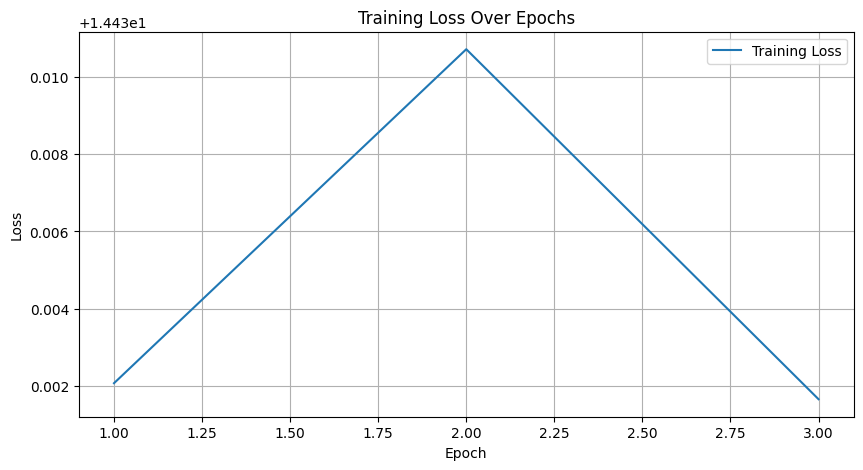

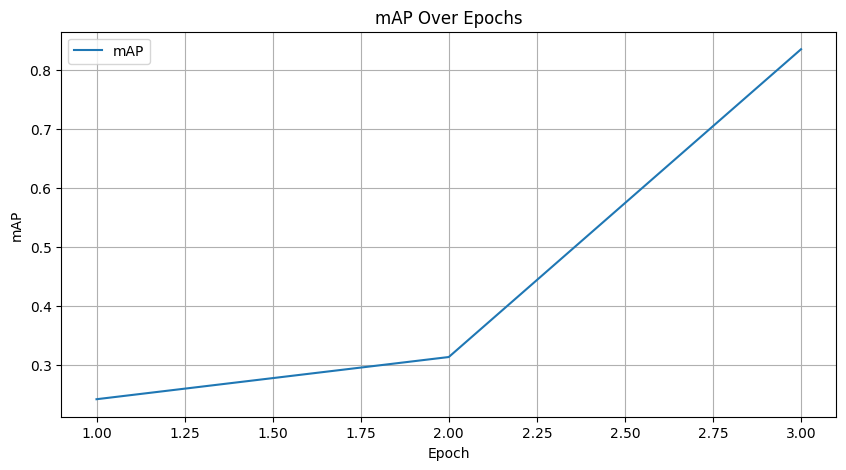

In [105]:
import torch
import torch.nn as nn
import math
import numpy as np

# ==================================
# 0. Helper Functions
# ==================================
def bbox_iou(box1, box2, xywh=True, GIoU=False, DIoU=False, CIoU=False, eps=1e-7):
    """
    Calculate IoU between boxes
    Args:
        box1: (tensor) Box 1, shape (n,4) or (4)
        box2: (tensor) Box 2, shape (n,4) or (4)
        xywh: (bool) If True, input boxes are in [x,y,w,h] format, otherwise [x1,y1,x2,y2]
        GIoU: (bool) Use GIoU
        DIoU: (bool) Use DIoU
        CIoU: (bool) Use CIoU
    """
    # Convert from center/width to corner coordinates
    if box1.ndim == 1:
        box1 = box1.unsqueeze(0)
    if box2.ndim == 1:
        box2 = box2.unsqueeze(0)

    if xywh:  # transform from xywh to xyxy
        b1_x, b1_y, b1_w, b1_h = box1.clone().T
        b2_x, b2_y, b2_w, b2_h = box2.clone().T
        box1_x1, box1_y1 = b1_x - b1_w / 2, b1_y - b1_h / 2
        box1_x2, box1_y2 = b1_x + b1_w / 2, b1_y + b1_h / 2
        box2_x1, box2_y1 = b2_x - b2_w / 2, b2_y - b2_h / 2
        box2_x2, box2_y2 = b2_x + b2_w / 2, b2_y + b2_h / 2
    else:  # xyxy format
        box1_x1, box1_y1, box1_x2, box1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        box2_x1, box2_y1, box2_x2, box2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    # Intersection area
    inter_x1 = torch.max(box1_x1, box2_x1)
    inter_y1 = torch.max(box1_y1, box2_y1)
    inter_x2 = torch.min(box1_x2, box2_x2)
    inter_y2 = torch.min(box1_y2, box2_y2)

    # Intersection area
    inter_w = (inter_x2 - inter_x1).clamp(min=0)
    inter_h = (inter_y2 - inter_y1).clamp(min=0)
    inter_area = inter_w * inter_h

    # Union Area
    w1, h1 = box1_x2 - box1_x1, box1_y2 - box1_y1
    w2, h2 = box2_x2 - box2_x1, box2_y2 - box2_y1

    union_area = (w1 * h1 + eps) + w2 * h2 - inter_area + eps

    # IoU
    iou = inter_area / union_area

    if GIoU or DIoU or CIoU:
        # Enclosing box
        encl_x1, encl_y1 = torch.min(box1_x1, box2_x1), torch.min(box1_y1, box2_y1)
        encl_x2, encl_y2 = torch.max(box1_x2, box2_x2), torch.max(box1_y2, box2_y2)
        encl_w, encl_h = encl_x2 - encl_x1, encl_y2 - encl_y1

        # GIoU
        if GIoU:
            encl_area = encl_w * encl_h + eps
            return iou - (encl_area - union_area) / encl_area

        # DIoU/CIoU
        c2 = encl_w**2 + encl_h**2 + eps  # Convex diagonal squared
        rho2 = ((box2_x1 + box2_x2 - box1_x1 - box1_x2)**2 +
                (box2_y1 + box2_y2 - box1_y1 - box1_y2)**2) / 4  # Center distance squared

        if DIoU:
            return iou - rho2 / c2

        # CIoU
        v = (4 / math.pi**2) * torch.pow(torch.atan(w2/h2) - torch.atan(w1/h1), 2)
        with torch.no_grad():
            alpha = v / (1 - iou + v + eps)
        return iou - (rho2 / c2 + v * alpha)

    return iou

# ==================================
# 1. Detection Head (YOLOv12Head)
# ==================================
class YOLOv12Head(nn.Module):
    """ YOLOv12 Detection Head """
    def __init__(self, nc=80, anchors=(), ch=()):
        super().__init__()
        if not ch:
            raise ValueError("Input channels 'ch' must be provided for YOLOv12Head")
        if not anchors:
            raise ValueError("Anchors must be provided for YOLOv12Head")

        self.nc = nc  # number of classes
        self.no = nc + 5  # number of outputs per anchor (classes + 5: x, y, w, h, obj)
        self.nl = len(anchors)  # number of detection layers (scales)
        self.na = len(anchors[0]) // 2  # number of anchors per layer
        self.grid = [torch.zeros(1)] * self.nl  # cache grid for forward
        self.stride = torch.tensor([8., 16., 32.])  # Store stride here

        # Register anchors as buffer
        a = torch.tensor(anchors).float().view(self.nl, -1, 2)
        self.register_buffer('anchors', a)  # shape(nl, na, 2)
        self.register_buffer('anchor_grid', a.clone().view(self.nl, 1, -1, 1, 1, 2))  # shape(nl, 1, na, 1, 1, 2)

        # Output convolution layer for each scale
        self.m = nn.ModuleList(nn.Conv2d(x, self.no * self.na, 1) for x in ch)

    def forward(self, x):
        z = []  # output for inference
        outputs = []
        for i in range(self.nl):  # Iterate through each scale (layer)
            x[i] = self.m[i](x[i])  # Apply Conv 1x1
            bs, _, ny, nx = x[i].shape  # batch_size, channels, grid_y, grid_x
            x[i] = x[i].view(bs, self.na, self.no, ny, nx).permute(0, 1, 3, 4, 2).contiguous()

            if not self.training:  # During inference
                if self.grid[i].shape[2:4] != x[i].shape[2:4]:
                    self.grid[i] = self._make_grid(nx, ny).to(x[i].device)

                xy = (x[i][..., 0:2].sigmoid() * 2. - 0.5 + self.grid[i]) * self.stride[i]  # bx, by
                wh = (x[i][..., 2:4].sigmoid() * 2) ** 2 * self.anchor_grid[i]  # bw, bh
                y = torch.cat((xy, wh, x[i][..., 4:].sigmoid()), -1)
                z.append(y.view(bs, -1, self.no))

            outputs.append(x[i])  # Store output for training

        return outputs if self.training else (torch.cat(z, 1), outputs)

    @staticmethod
    def _make_grid(nx=20, ny=20):
        yv, xv = torch.meshgrid([torch.arange(ny), torch.arange(nx)], indexing='ij')
        return torch.stack((xv, yv), 2).view((1, 1, ny, nx, 2)).float()

# ==================================
# 2. Loss Function (YOLOv12Loss)
# ==================================
class YOLOv12Loss(nn.Module):
    def __init__(self, head_module, hyp, device):
        super().__init__()
        self.head = head_module
        self.nc = head_module.nc
        self.na = head_module.na
        self.nl = head_module.nl
        self.anchors = head_module.anchors
        self.stride = head_module.stride

        self.hyp = hyp
        self.device = device

        self.BCEcls = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([hyp.get('cls_pw', 1.0)], device=device))
        self.BCEobj = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([hyp.get('obj_pw', 1.0)], device=device))

        self.balance = [4.0, 1.0, 0.4]
        self.anchor_t = hyp.get('anchor_t', 4.0)

    def forward(self, preds, targets):
        device = targets.device
        lcls, lbox, lobj = torch.zeros(1, device=device), torch.zeros(1, device=device), torch.zeros(1, device=device)
        tcls, tbox, indices, anchors_target = self.build_targets(preds, targets)

        for i, pi in enumerate(preds):  # i = layer index, pi = predictions
            b, a, gj, gi = indices[i]  # image_index, anchor_index, grid_y, grid_x

            tobj = torch.zeros_like(pi[..., 0], device=device)  # target objectness

            n = b.shape[0]  # number of targets in this layer
            if n:
                ps = pi[b, a, gj, gi]  # predictions subset

                pxy = ps[:, :2].sigmoid() * 2. - 0.5
                pwh = (ps[:, 2:4].sigmoid() * 2) ** 2 * anchors_target[i]  # Use adjusted anchor target
                pbox = torch.cat((pxy, pwh), 1)  # [cx, cy, w, h] format

                # Use pbox directly for IoU calculation - no need for transposing
                iou = bbox_iou(pbox, tbox[i], xywh=True, CIoU=True)
                lbox += (1.0 - iou).mean()  # CIoU loss

                tobj[b, a, gj, gi] = 1.0

                if self.nc > 1:
                    t = torch.full_like(ps[:, 5:], 0, device=device)
                    t[range(n), tcls[i]] = 1.0
                    lcls += self.BCEcls(ps[:, 5:], t)

            obji = self.BCEobj(pi[..., 4], tobj)
            lobj += obji * self.balance[i]

        lbox *= self.hyp.get('box', 0.05)
        lobj *= self.hyp.get('obj', 1.0)
        lcls *= self.hyp.get('cls', 0.5)

        bs = preds[0].shape[0]
        loss = lbox + lobj + lcls
        return loss * bs, torch.cat((lbox, lobj, lcls)).detach()

    def build_targets(self, preds, targets):
        na = self.na
        nt = targets.shape[0]
        tcls, tbox, indices, anch = [], [], [], []
        gain = torch.ones(7, device=targets.device)

        ai = torch.arange(na, device=targets.device).float().view(na, 1).repeat(1, nt)
        targets = torch.cat((targets.repeat(na, 1, 1), ai[:, :, None]), 2)

        g = 0.5
        off = torch.tensor([[0, 0], [1, 0], [0, 1], [-1, 0], [0, -1]], device=targets.device).float() * g

        for i in range(self.nl):
            anchors = self.anchors[i]
            gain[2:6] = torch.tensor(preds[i].shape)[[3, 2, 3, 2]]

            t = targets * gain
            if nt:
                r = t[:, :, 4:6] / anchors[:, None]
                j = torch.max(r, 1. / r).max(2)[0] < self.anchor_t
                t = t[j]

                gxy = t[:, 2:4]
                gxi = gain[[2, 3]] - gxy

                # Handle boundary cases
                gc_l = gxy % 1. < g
                gc_r = gxy % 1. > (1-g)

                # Create extra targets for grid cells at boundaries
                j1 = (gc_l[:, 0]) & (gxy[:, 0] > 1.)
                j2 = (gc_r[:, 0]) & (gxi[:, 0] > 1.)
                j3 = (gc_l[:, 1]) & (gxy[:, 1] > 1.)
                j4 = (gc_r[:, 1]) & (gxi[:, 1] > 1.)

                # Combine additional targets
                t = torch.cat((t, t[j1], t[j2], t[j3], t[j4]), 0) if self.hyp.get('use_neighbor_sampling', True) else t

            else:
                t = targets[0]

            b, c = t[:, :2].long().T
            gxy = t[:, 2:4]
            gwh = t[:, 4:6]
            gij = gxy.long()
            gi, gj = gij.T

            a = t[:, 6].long()

            indices.append((b, a, gj.clamp(0, gain[3] - 1).to(torch.long), gi.clamp(0, gain[2] - 1).to(torch.long)))
            tbox.append(torch.cat((gxy - gij, gwh), 1))  # box [cx, cy, w, h] format
            anch.append(anchors[a])
            tcls.append(c)

        return tcls, tbox, indices, anch


# ==================================
# 3. Training & Evaluation Framework
# ==================================

import argparse
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Placeholder untuk fungsi evaluasi mAP (Anda perlu mengimplementasikannya)
def evaluate_mAP(model, data_loader, device, num_classes):
    """
    Fungsi ini harus mengimplementasikan logika evaluasi mAP.
    Karena kita menggunakan data dummy dalam pelatihan, fungsi ini hanya akan mengembalikan nilai dummy.
    Dalam implementasi sebenarnya, Anda akan:
    1. Mengatur model ke mode evaluasi (model.eval()).
    2. Melakukan iterasi melalui data loader validasi.
    3. Mendapatkan prediksi dari model.
    4. Memproses prediksi (misalnya, menerapkan ambang batas kepercayaan diri, NMS).
    5. Membandingkan prediksi dengan ground truth.
    6. Menghitung metrik Presisi, Recall, dan AP untuk setiap kelas.
    7. Menghitung mAP (rata-rata AP di semua kelas).
    """
    print("Melakukan evaluasi mAP (placeholder)...")
    # Contoh pengembalian nilai dummy
    return np.random.rand()

def train(hyp, opt, device):
    epochs = opt.epochs
    batch_size = opt.batch_size
    data_yaml = opt.data
    weights = opt.weights
    save_dir = opt.save_dir

    nc = 80
    neck_channels = (256, 512, 768)
    anchors = [
        [10,13, 16,30, 33,23],
        [30,61, 62,45, 59,119],
        [116,90, 156,198, 373,326]
    ]

    model = YOLOv12Head(nc=nc, anchors=anchors, ch=neck_channels).to(device)
    model.stride = torch.tensor([8., 16., 32.]).to(device)

    optimizer = optim.Adam(model.parameters(), lr=hyp.get('lr0', 0.001), betas=(hyp.get('momentum', 0.9), 0.999))

    compute_loss = YOLOv12Loss(model, hyp, device)

    print(f"Starting training for {epochs} epochs...")

    # List untuk menyimpan nilai loss per epoch
    training_losses = []
    mAP_values = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        loss_items_epoch = torch.zeros(3, device=device)

        num_batches = 10
        for i in range(num_batches):
            # --- Dummy Data ---
            bs = batch_size
            h_dummy, w_dummy = 640, 640
            # Create dummy predictions according to head output
            dummy_preds = []
            dummy_preds.append(torch.randn(bs, model.na, h_dummy // 8, w_dummy // 8, model.no, device=device, requires_grad=True))
            dummy_preds.append(torch.randn(bs, model.na, h_dummy // 16, w_dummy // 16, model.no, device=device, requires_grad=True))
            dummy_preds.append(torch.randn(bs, model.na, h_dummy // 32, w_dummy // 32, model.no, device=device, requires_grad=True))

            # Create dummy targets [num_targets, 6] -> (img_idx, class, cx, cy, w, h)
            num_dummy_targets = 5
            dummy_targets = torch.zeros(num_dummy_targets, 6, device=device, requires_grad=False)
            dummy_targets[:, 0] = torch.randint(0, bs, (num_dummy_targets,))  # img_idx < batch_size
            dummy_targets[:, 1] = torch.randint(0, nc, (num_dummy_targets,))  # class_idx < num_classes
            dummy_targets[:, 2:6] = torch.rand(num_dummy_targets, 4)  # cx, cy, w, h (normalized 0-1)
            # --- End of Dummy Data ---

            optimizer.zero_grad()

            # Forward pass (Use real data: outputs = model(images))
            outputs = dummy_preds  # Use dummy preds for loss

            # Calculate loss (Use real data: loss, loss_items = compute_loss(outputs, targets))
            loss, loss_items = compute_loss(outputs, dummy_targets)

            # Backward pass & optimizer step
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            loss_items_epoch += loss_items

            if i % 1 == 0:  # Log every batch (or as desired)
                print(f'  Batch {i+1}/{num_batches}, Loss: {loss.item():.4f} (Box: {loss_items[0]:.4f}, Obj: {loss_items[1]:.4f}, Cls: {loss_items[2]:.4f})')

        avg_loss = running_loss / num_batches
        avg_loss_items = loss_items_epoch / num_batches
        print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}")
        print(f"  Avg Box Loss: {avg_loss_items[0]:.4f}, Avg Obj Loss: {avg_loss_items[1]:.4f}, Avg Cls Loss: {avg_loss_items[2]:.4f}")

        training_losses.append(avg_loss)

        # Evaluasi mAP setiap epoch (Anda mungkin ingin menyesuaikan frekuensi ini)
        model.eval() # Set model to evaluation mode
        with torch.no_grad():
            mAP = evaluate_mAP(model, None, device, nc) # Anda perlu mengganti None dengan data loader validasi Anda
            print(f"  mAP: {mAP:.4f}")
            mAP_values.append(mAP)
        
        # Check if mAP reaches 0.8, stop training if it does
        if mAP >= 0.8:
            print(f"mAP reached {mAP:.4f}, stopping training.")
            break

        model.train() # Set model back to training mode

    # Plotting the loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epoch + 2), training_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{save_dir}/training_loss.png')
    plt.show()

    # Plotting the mAP (optional)
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epoch + 2), mAP_values, label='mAP')
    plt.xlabel('Epoch')
    plt.ylabel('mAP')
    plt.title('mAP Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{save_dir}/mAP.png')
    plt.show()


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--data', type=str, default='data/coco128.yaml', help='Path to dataset .yaml file')
    parser.add_argument('--weights', type=str, default='', help='Path to initial weights (.pt)')
    parser.add_argument('--epochs', type=int, default=10)
    parser.add_argument('--batch-size', type=int, default=4)
    parser.add_argument('--img-size', nargs='+', type=int, default=[640, 640])
    parser.add_argument('--device', default='', help='cuda device, i.e. 0 or 0,1,2,3 or cpu')
    parser.add_argument('--save-dir', default='runs/train/exp', help='Directory to save results')

    opt, unknown = parser.parse_known_args()
    print("Unknown arguments (ignored):", unknown)

    hyp = {
        'lr0': 0.001,
        'momentum': 0.9,
        'weight_decay': 0.0005,
        'box': 0.05,
        'cls': 0.3,
        'cls_pw': 1.0,
        'obj': 0.7,
        'obj_pw': 1.0,
        'anchor_t': 4.0,
        'use_neighbor_sampling': True
    }

    if opt.device:
        device = torch.device(opt.device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    train(hyp, opt, device)